In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from algo_sample import *
from algo_tom import *
from algo_utils import *
# import talib

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [34]:
vic = pd.read_csv("../../data/vic_train.csv")
vic = vic.loc[1:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
#vic.index = vic.time
#vic = vic.drop(columns='time')

vic_cv = pd.read_csv("../../data/vic_cv.csv")
vic_cv = vic_cv.loc[1:].reset_index(drop=True)
vic_cv['time'] = vic_cv['time'].astype('datetime64[ns]')
vic_cv['year'] = vic_cv['time'].dt.year
#vic_cv.index = vic_cv.time
#vic_cv = vic_cv.drop(columns='time')
vic.head()

,time,spot_price,inter_gen,demand,period,year
0,2018-01-01 00:30:00,92.46,131.68,4398,2,2018
1,2018-01-01 01:00:00,87.62,119.98,4238,3,2018
2,2018-01-01 01:30:00,73.08,123.86,4112,4,2018
3,2018-01-01 02:00:00,70.18,132.72,3956,5,2018
4,2018-01-01 02:30:00,67.43,120.73,3833,6,2018


In [35]:
def calc_a3_raw_power(percentage, forecast, opening_capacity, battery_power=BATTERY_POWER,
                      battery_capacity=BATTERY_CAPACITY, charge_efficiency=CHARGE_EFFICIENCY,
                      discharge_efficiency=DISCHARGE_EFFICIENCY):
    if (forecast == -1):
        return -min(battery_power * percentage, (battery_capacity - opening_capacity)/(charge_efficiency/100)*2)
    elif (forecast == 1):
        return min(battery_power * percentage, opening_capacity*2)
    else:
        return 0

        
def init_percentage(df):
    # set all percentage to 1 if predict a charge or discharge
    df['percentage'] = 1
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        if forecast == 0:
            arr_curr[percentage_idx] = 0
    df[:] = arr
    return df

def compute_algo(df):
    """
    Notes: Compute forecast using algorithm 3 raw power function
    ----------
    Parameters
    ----------
    df    : dataframe with spot_price & forecast columns
    Returns
    -------
    df    : dataframe
    """
    df = df.copy(deep=False)

    # create columns
    df['raw_power'] = 0
    df['market_dispatch'] = 0
    df['market_revenue'] = 0
    df['closing_capacity'] = 0

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    raw_power_idx = columns.index('raw_power')
    market_dispatch_idx = columns.index('market_dispatch')
    market_revenue_idx = columns.index('market_revenue')
    closing_capacity_idx = columns.index('closing_capacity')
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):

        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
        if i == 0:
            opening_capacity = 0
        else:
            opening_capacity = arr[i-1][closing_capacity_idx]

        forecast = arr_curr[forecast_idx]
        if forecast == 0:
            arr_curr[percentage_idx] = 0
        percentage = arr_curr[percentage_idx]

        raw_power = calc_a3_raw_power(
            percentage, forecast, opening_capacity)  # calc raw power
        market_dispatch = calc_market_dispatch(
            raw_power)  # calc market dispatch
        market_revenue = calc_market_revenue(
            market_dispatch, spot_price)  # calc market revenue
        closing_capacity = calc_closing_capacity(
            market_dispatch, opening_capacity)  # calc closing capacity

        # read value into array
        arr_curr[raw_power_idx] = raw_power
        arr_curr[market_dispatch_idx] = market_dispatch
        arr_curr[closing_capacity_idx] = closing_capacity
        arr_curr[market_revenue_idx] = market_revenue

    # replace df columns with np array
    df[:] = arr

    return df

In [36]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
df_train = init_percentage(df_train)
df_train = compute_algo(df_train)

print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())
df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = init_percentage(df_test)
df_test = compute_algo(df_test)
print('2021 Revenue:', df_test.market_revenue.sum(), '\n')
print("total:", df_test.market_revenue.sum()+df_train.market_revenue.sum())

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2018.00   31024970.00
2019.00   41485023.00
2020.00   28725062.00
Name: market_revenue, dtype: float64
Total Revenue: 101235055.0
2021 Revenue: 16858801.0 

total: 118093856.0


In [37]:
def set_percentage(df):
    # set percentage to 1 if predict a charge or discharge
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        if forecast != 0:
            arr_curr[percentage_idx] = 1
    df[:] = arr
    return df

In [38]:
def filter_3(df):
    """
    Notes: Compute forecast using algorithm 3 raw power function
    ----------
    Parameters
    ----------
    df    : dataframe with spot_price & forecast columns
    
    Returns
    -------
    df    : dataframe
    """
#     df = pd.DataFrame({'spot_price': spot_price, 'forecast': forecast, 'org_index': org_index}).reset_index(drop = True)
    

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
   
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
        if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
        
        # stop when not continue

        else:
            max_idx = np.argmax([item[1] for item in cur_df]) # find the maximum spot_price position
            cur_df = cur_df[0:max_idx+1]
           
            min_idx = np.argmin([item[1] for item in cur_df]) # find the minimum spot_price position
            min_price  = cur_df[min_idx][1]
            max_price = cur_df[max_idx][1]

            
            # choose charge price
            if max_price > min_price*1.26:
                char_idx = cur_df[min_idx][0]
                arr[char_idx][forecast_idx] = -1

                dischar_idx = cur_df[max_idx][0]
                arr[dischar_idx][forecast_idx] = 1

                
            
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
    



    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [39]:
def filter_4(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')


    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
   
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
        if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
        
        # Start from here: different from fliter 3 ==================
        else: 
            max_idx = np.argmax([item[1] for item in cur_df]) # find the maximum spot_price position
            cur_df = cur_df[max_idx:]
           
            min_idx = np.argmin([item[1] for item in cur_df]) # find the minimum spot_price position
            min_price  = cur_df[min_idx][1]
            max_price = cur_df[0][1]

            
            # choose charge price
            if max_price > min_price*1.26:
                char_idx = cur_df[min_idx][0]
                arr[char_idx][forecast_idx] = -1
                
                dischar_idx = cur_df[0][0]
                arr[dischar_idx][forecast_idx] = 1

        # ==========================================        
            
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
    
    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [40]:
def filter_5(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
   
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
        if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
        
        # stop when not continue
        # Start from here: different from fliter 4 ==================
        else:
            max_difference = 0
            max_difference_combination=[]
            for row_a in cur_df:
                for row_b in cur_df: # check is there an decreasing trend
                    if (row_a[0] < row_b[0]) and (row_a[1] > row_b[1]*1.26) and ((row_a[1] - row_b[1])> max_difference):
                        max_difference = row_a[1] - row_b[1]
                        max_difference_combination = [row_a, row_b]

            if len(max_difference_combination) > 0:
                dischar_idx = max_difference_combination[0][0]
                char_idx = max_difference_combination[1][0]

                arr[char_idx][forecast_idx] = -1
                arr[dischar_idx][forecast_idx] = 1
            

        # ==============================================================
                           
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
    

    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [41]:
def filter_6(df):

    # get column index
    columns = list(df.columns)
    spot_price_idx = columns.index('spot_price')
    forecast_idx = columns.index('forecast')
    index_idx = columns.index('org_index')

    arr = df.to_numpy()
    i =1
    cur_df = [[0, arr[0][spot_price_idx]]]
   
    while i < len(arr):
        
        arr_curr = arr[i]
        spot_price = arr_curr[spot_price_idx]
       
        if arr_curr[index_idx] == (arr[i-1][index_idx] + 1):  # if they are continue sequence
            cur_df.append([i, spot_price]) # store the current position and price
            i = i + 1
        
        # stop when not continue
        # Start from here: different from fliter 5 ==================
        else:
            max_difference = 0
            max_difference_combination=[]
            for row_a in cur_df:
                for row_b in cur_df: # check is there an increasing trend
                    if (row_a[0] < row_b[0]) and (row_a[1]*1.26 < row_b[1]) and ((row_b[1] - row_a[1])> max_difference):
                        max_difference = row_b[1] - row_a[1]
                        max_difference_combination = [row_a, row_b]

            if len(max_difference_combination) > 0:
                dischar_idx = max_difference_combination[1][0]
                char_idx = max_difference_combination[0][0]

                arr[char_idx][forecast_idx] = -1
                arr[dischar_idx][forecast_idx] = 1
            

        # ==============================================================
                           
            # reset cur_df
            cur_df = [[i, arr[i][spot_price_idx]]]
            i = i+1
    

    df[:] = arr
    forecast = df.forecast
#     print(arr)
    return forecast.to_numpy()

In [42]:
def set_percentage_for_fliter5(df):
    
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        percentage = arr_curr[percentage_idx]

        # set percentage to 0.9 if discharge occurs in the fliter 5
        if (forecast == 1) and (percentage == 0):
            arr_curr[percentage_idx] = 0.89


        # set percentage to 1 if charge occurs in the fliter 5
        if (forecast == -1) and (percentage == 0):
            arr_curr[percentage_idx] = 1

    df[:] = arr
    return df


def set_percentage_for_fliter3(df):
    
    columns = list(df.columns)
    forecast_idx = columns.index('forecast')
    percentage_idx = columns.index('percentage')

    arr = df.to_numpy()
    for i in range(len(arr)):
        arr_curr = arr[i]
        forecast = arr_curr[forecast_idx]
        percentage = arr_curr[percentage_idx]

        # set percentage to 1 if discharge occurs in the fliter 3
        if (forecast == 1) and (percentage == 0):
            arr_curr[percentage_idx] = 1


        # set percentage to 1 if charge occurs in the fliter 3
        if (forecast == -1) and (percentage == 0):
            arr_curr[percentage_idx] = 1

    df[:] = arr
    return df


In [43]:
start = 30455  #30455
end =30555 #30555

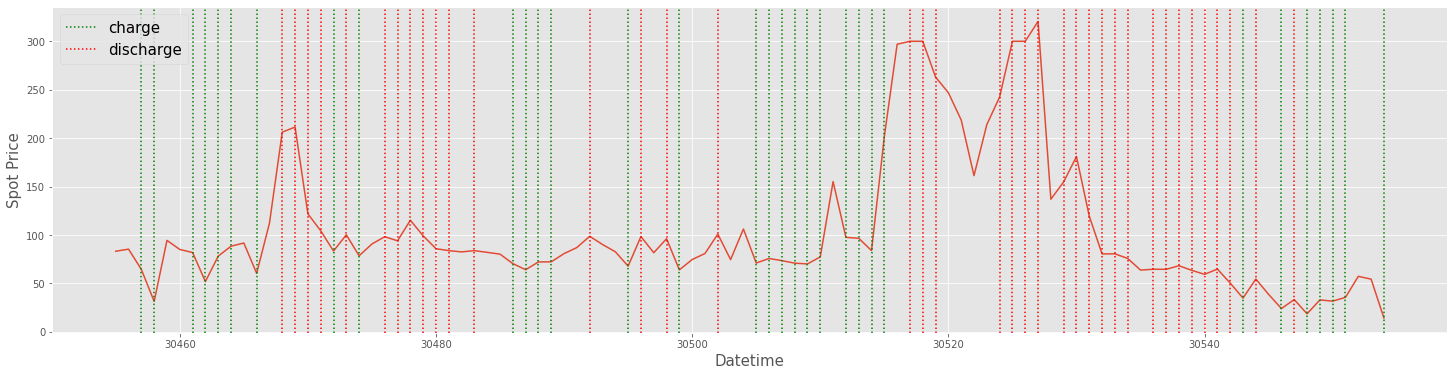

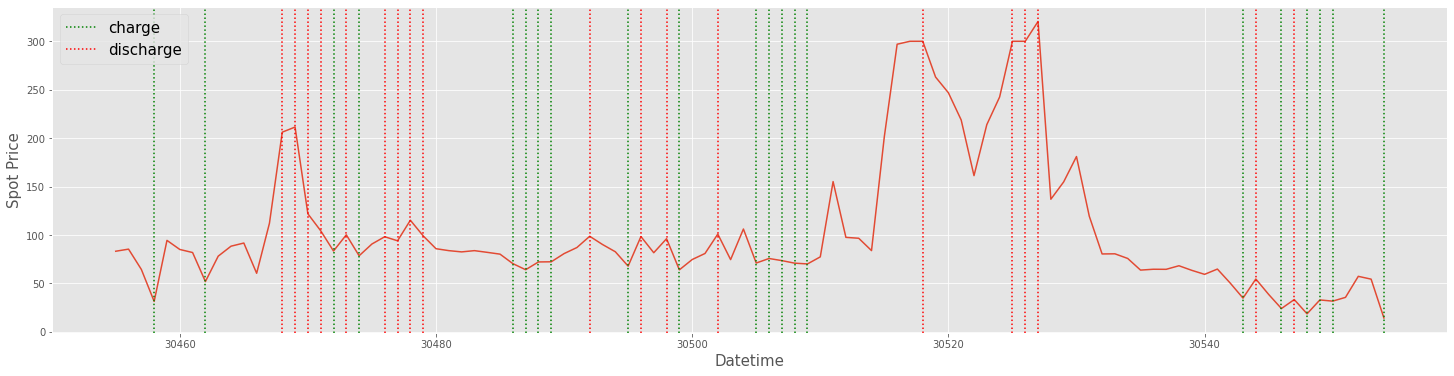

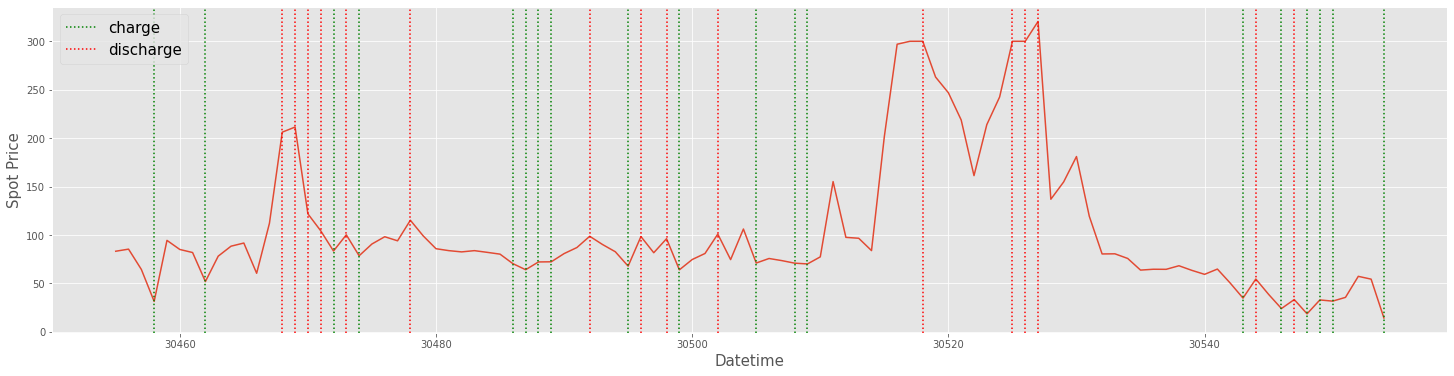

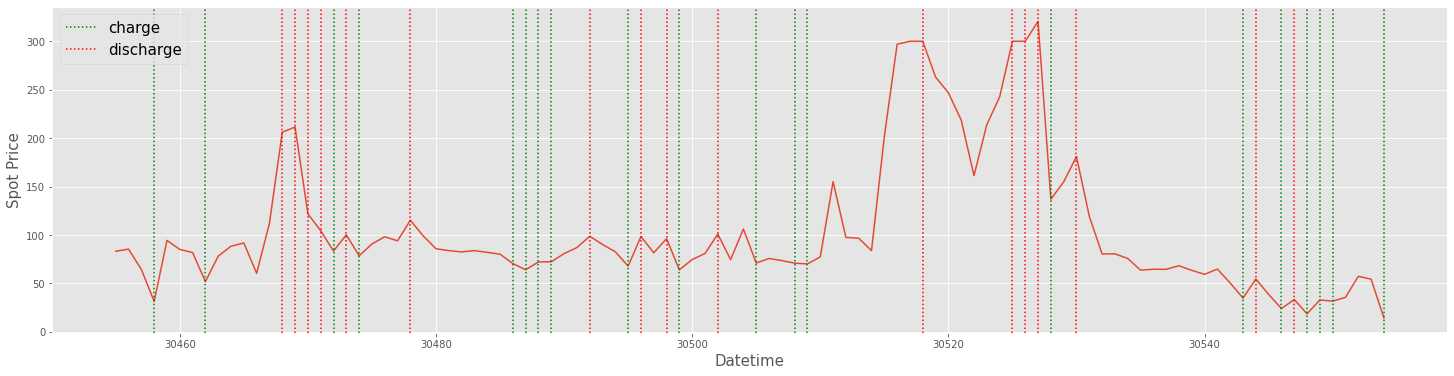

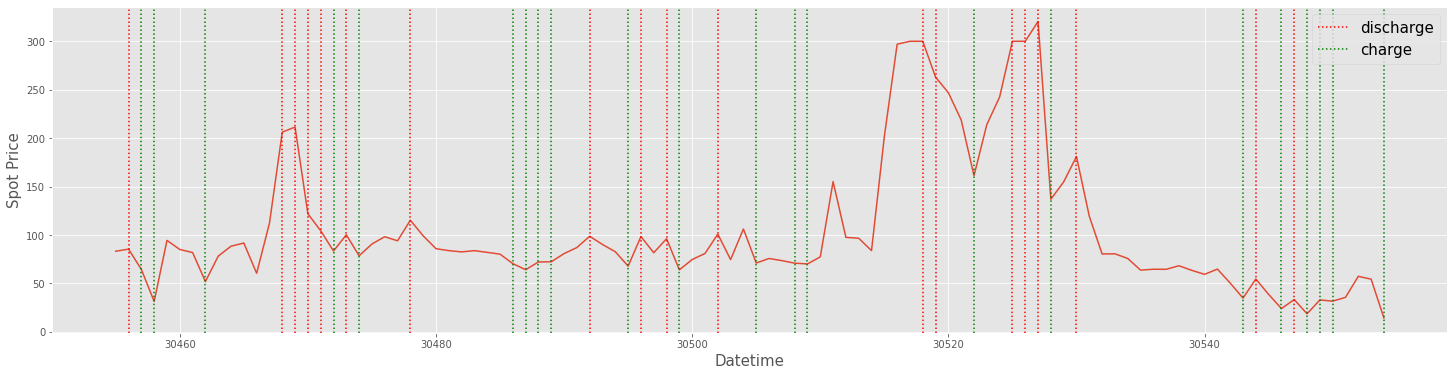

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2018.00   31523327.00
2019.00   42155440.00
2020.00   29004971.00
Name: market_revenue, dtype: float64
Total Revenue: 102683738.0
2021 Revenue: 17129453.0 

total: 119813191.0


In [44]:
# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

df_train = init_percentage(df_train)
df_train = compute_algo(df_train)


for i in range(3):
    # more filter 3 =============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_3(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =========================

plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

# more filter 4 ===============
space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 580)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)

df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)

space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 430)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)
# end =============

plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)

df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)

for i in range(3):
    # more filter 5 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 135)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_5(space)

    df_train = set_percentage_for_fliter5(df_train)
    df_train = compute_algo(df_train)
    # end =============

for i in range(3):
    # more filter 6 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_6(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =============


print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())

####################################### CV ######################################

df_test = vic_cv.copy(deep=False)[['spot_price', 'period', 'year']]
df_test['forecast'] = calc_forecast_tom_2(df_test.spot_price)
df_test['forecast'] = filter_forecast(df_test.spot_price, df_test.forecast)
df_test['forecast'] = optimize_combination(df_test.spot_price, df_test.forecast)
df_test = init_percentage(df_test)
df_test = compute_algo(df_test)


for i in range(3):
    # more filter 3
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_3(space)

    df_test = set_percentage_for_fliter3(df_test)
    df_test = compute_algo(df_test)
    # end

# more filter 4
space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 580)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_test.loc[idx, 'forecast'] = filter_4(space)
# end

df_test = set_percentage_for_fliter5(df_test)
df_test = compute_algo(df_test)

for i in range(3):
    # more filter 5
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] >= 135)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_5(space)

    df_test = set_percentage_for_fliter5(df_test)
    df_test = compute_algo(df_test)

for i in range(3):
    # more filter 6
    space = df_test.loc[(df_test['raw_power'] == 0) & (df_test['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_test.loc[idx, 'forecast'] = filter_6(space)

    df_test = set_percentage_for_fliter3(df_test)
    df_test = compute_algo(df_test)
    # end

print('2021 Revenue:', df_test.market_revenue.sum(), '\n')
print("total:", df_test.market_revenue.sum()+df_train.market_revenue.sum())


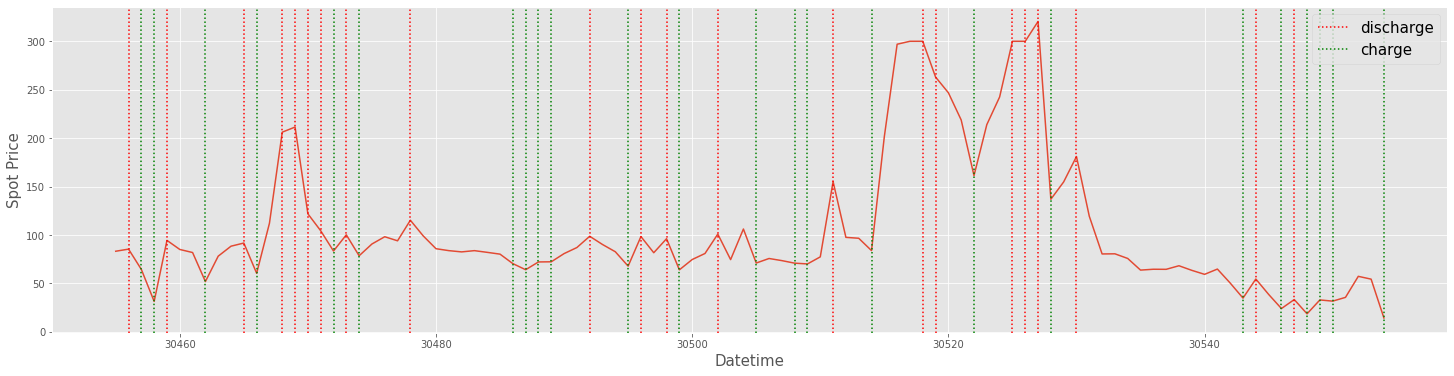

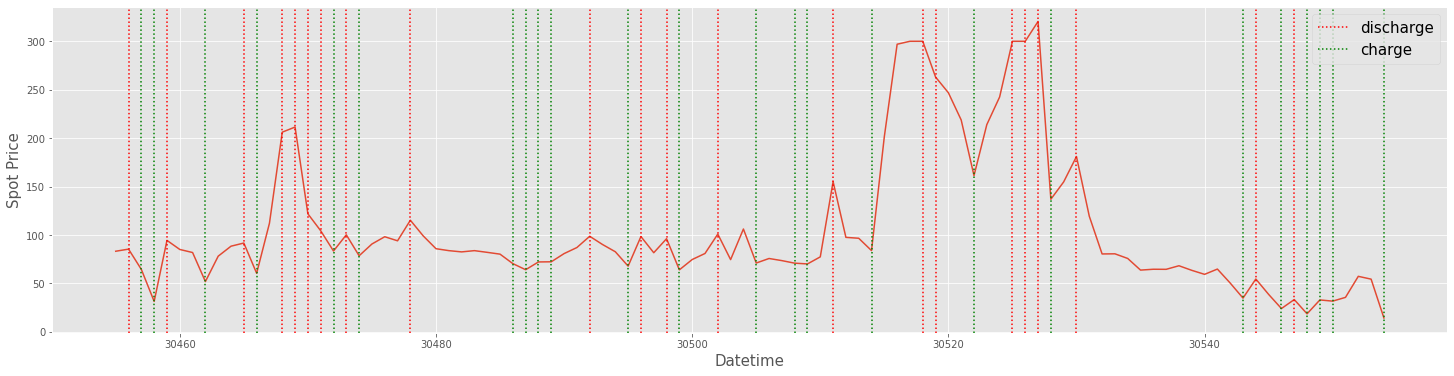

In [45]:
start = 30455  #30455
end =30555 #30555
plot_actions(df_train.spot_price, df_train.forecast, start=start, end=end)
plot_actions(df_train.spot_price, df_train.raw_power, start=start, end=end)


In [46]:
df_train[30510:30530+1]

,spot_price,period,year,forecast,percentage,raw_power,market_dispatch,market_revenue,closing_capacity
30510,77.45,32.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30511,155.15,33.00,2019.00,1.00,0.89,267.00,120.00,18450.00,447.00
30512,97.59,34.00,2019.00,0.00,0.00,0.00,0.00,0.00,447.00
30513,96.67,35.00,2019.00,0.00,0.00,0.00,0.00,0.00,447.00
30514,83.93,36.00,2019.00,-1.00,1.00,-295.56,-148.00,-12534.00,580.00
30515,201.60,37.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30516,296.95,38.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30517,299.99,39.00,2019.00,0.00,0.00,0.00,0.00,0.00,580.00
30518,299.99,40.00,2019.00,1.00,1.00,300.00,135.00,40134.00,430.00
30519,263.07,41.00,2019.00,1.00,0.89,267.00,120.00,31284.00,297.00


In [47]:
VIC = pd.read_csv('../../data/vic.csv')
data = VIC[(VIC['time'] >= "2021-06-07 00:00:00") & (VIC['time'] < "2021-06-08 00:00:00")].reset_index(drop=True)
#data.sort_values(['spot_price'])
vic = data.loc[:].reset_index(drop=True)
vic['time'] = vic['time'].astype('datetime64[ns]')
vic['year'] = vic['time'].dt.year
vic


,time,spot_price,inter_gen,demand,period,year
0,2021-06-07 00:00:00,3.03,333.19,5065,1,2021
1,2021-06-07 00:30:00,3.38,343.35,4903,2,2021
2,2021-06-07 01:00:00,-12.51,353.23,4753,3,2021
3,2021-06-07 01:30:00,-7.24,364.31,4628,4,2021
4,2021-06-07 02:00:00,-31.56,381.00,4424,5,2021
5,2021-06-07 02:30:00,-31.63,392.10,4314,6,2021
6,2021-06-07 03:00:00,-31.59,397.85,4224,7,2021
7,2021-06-07 03:30:00,-31.64,403.27,4155,8,2021
8,2021-06-07 04:00:00,-31.64,410.82,4107,9,2021
9,2021-06-07 04:30:00,-32.51,416.18,4154,10,2021


In [52]:

# Algo Test Tom 2 (with forecast filtered & combination optimization)
df_train = vic.copy(deep=False)[['spot_price', 'period', 'year']]
df_train['forecast'] = calc_forecast_tom_2(df_train.spot_price)


df_train['forecast'] = filter_forecast(df_train.spot_price, df_train.forecast)


df_train['forecast'] = optimize_combination(df_train.spot_price, df_train.forecast)


df_train = init_percentage(df_train)
df_train = compute_algo(df_train)


for i in range(3):
    # more filter 3 =============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_3(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =========================



# more filter 4 ===============
space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 580)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)

df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)

space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 430)].iloc[:, [0,3,]]
space['org_index'] = space.index
space = space.reset_index(drop=True)
idx = space.org_index.to_list()
df_train.loc[idx, 'forecast'] = filter_4(space)
# end =============



df_train = set_percentage_for_fliter5(df_train)
df_train = compute_algo(df_train)

for i in range(3):
    # more filter 5 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] >= 135)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_5(space)

    df_train = set_percentage_for_fliter5(df_train)
    df_train = compute_algo(df_train)
    # end =============

for i in range(3):
    # more filter 6 ===============
    space = df_train.loc[(df_train['raw_power'] == 0) & (df_train['closing_capacity'] == 0)].iloc[:, [0,3,]]
    space['org_index'] = space.index
    space = space.reset_index(drop=True)
    idx = space.org_index.to_list()
    df_train.loc[idx, 'forecast'] = filter_6(space)

    df_train = set_percentage_for_fliter3(df_train)
    df_train = compute_algo(df_train)
    # end =============


print('=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===')
print(df_train.groupby('year').market_revenue.sum())
print('Total Revenue:', df_train.market_revenue.sum())

=== Algorithm Test Tom 2 (with forecast filtered & combination optimization) ===
year
2021.00   99146.00
Name: market_revenue, dtype: float64
Total Revenue: 99146.0


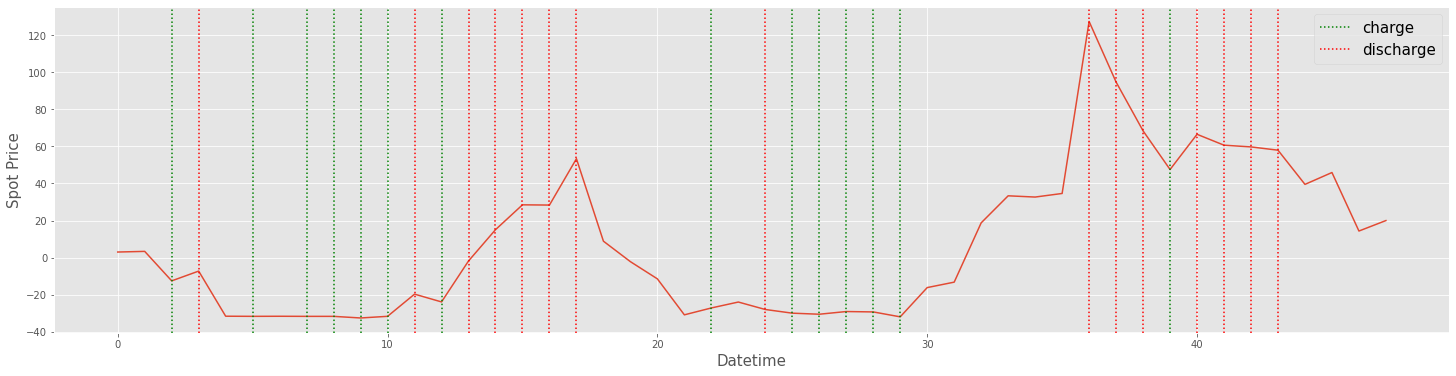

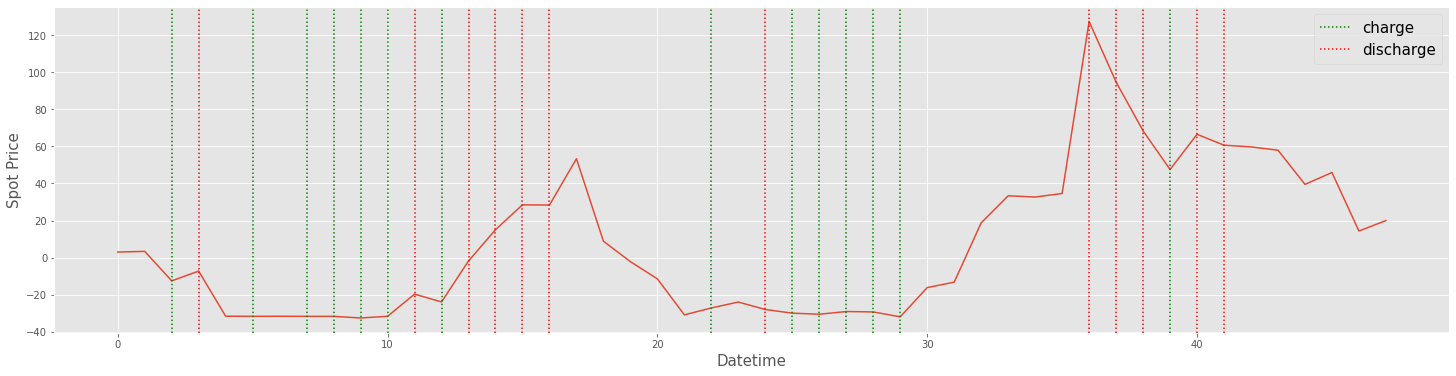

,spot_price,period,year,forecast,percentage,raw_power,market_dispatch,market_revenue,closing_capacity
0,3.03,1.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3.38,2.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-12.51,3.00,2021.00,-1.00,1.00,-300.00,-150.00,1894.00,135.00
3,-7.24,4.00,2021.00,1.00,1.00,270.00,122.00,-875.00,0.00
4,-31.56,5.00,2021.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-31.63,6.00,2021.00,-1.00,1.00,-300.00,-150.00,4788.00,135.00
6,-31.59,7.00,2021.00,0.00,0.00,0.00,0.00,0.00,135.00
7,-31.64,8.00,2021.00,-1.00,1.00,-300.00,-150.00,4789.00,270.00
8,-31.64,9.00,2021.00,-1.00,1.00,-300.00,-150.00,4789.00,405.00
9,-32.51,10.00,2021.00,-1.00,1.00,-300.00,-150.00,4921.00,540.00


In [50]:
plot_actions(df_train.spot_price, df_train.forecast)
plot_actions(df_train.spot_price, df_train.raw_power)
df_train